
# Download ERA5 data for METFUT

1. Understand the task: METFUT would like to train ML models on subsets of ERA5 data. For this, we should retrieve snapshots of individual variables on single model levels at 12-hourly resolution. The variable names/ids, model levels, and time ranges will be given to us.
2. Read through the [ERA5 documentation](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-complete?tab=form) to understand the data structure and identify, which data/access point we need.
3. Install the CDS API.
   * For this, we first need to register at [Copernicus Data Store](https://cds.climate.copernicus.eu/user/register?destination=%2F%23!%2Fhome).
   * Next copy and store your API key in file ```$HOME/.cdsapirc```. You find it at the bottom of your personal profile when you are logged in the CDS. Format:
```
url: https://cds.climate.copernicus.eu/api/v2
key: {uid}:{api-key}
```
   *Install the CDS API via ```pip install cdsapi```
   * Read through the [instructions](https://cds.climate.copernicus.eu/api-how-to) on how to use the cdsapi (bottom half of web page))
5. Browse through the [ERA5 data catalogue](https://apps.ecmwf.int/data-catalogues/era5/?class=ea) and select the fields you want to download.
6. After composing your search, click on "Show API request" and copy the commands into your notebook.

Please make sure to limit the download to 5.625 degree resolution and 12-hourly samples! Select Netcdf as output format. 

In [27]:
# install modules
#!pip install cdsapi
#!pip install xarray

__Note:__ The following works with the ipynb kernel, but not with the METCLOUD kernel. The first try might raise an error telling you that you must first accept the use conditions (follow the link at the bottom). Thereafter, it should work.

In [28]:
# Exemplary MARS request after composing through the web interface
# shortened from 1 month to 3 days
import cdsapi

c = cdsapi.Client()

# c.retrieve("reanalysis-era5-complete", {
#     "class": "ea",
#     "date": "2023-01-01/to/2023-01-31",
#     "expver": "1",
#     "levelist": "137",
#     "levtype": "ml",
#     "param": "130",
#     "step": "0",
#     "stream": "oper",
#     "time": "21:00:00",
#     "type": "4v"
# }, "output")


## Customize requests 
Now, we need to modify the request to obtain what we really want:
* time 09:00 and 21:00
* 5.625 degree resolution
* Netcdf output

Check the [Guidelines for efficient MARS requests](https://confluence.ecmwf.int/display/UDOC/Guidelines+to+write+efficient+MARS+requests) how to make these modifications.

Question: how to use "list" and "output = cost" in cdsapi?

See also [MARS user documentation](https://confluence.ecmwf.int/display/UDOC/MARS+user+documentation)

From efficiency guide: loop structure should be
```
date (outer loop)
   time
      step
         number (EPS only)
            level
               parameter (inner loop)
```
Try to issue the MARS request at the highest level possible.

In [75]:
c.retrieve("reanalysis-era5-complete", {
    "class": "ea",
    "date": "2023-01-01",
    "expver": "1",
    "levelist": "137",
    "levtype": "sfc",
    "grid": "5.625/5.625",
    "param": "167.128",
    "step": "0",
    "stream": "oper",
    "time": "09:00:00/21:00:00",
    "type": "4v",
    "format": "netcdf",
}, "surfacedata.nc")

2024-05-15 12:29:36,213 INFO Welcome to the CDS
2024-05-15 12:29:36,213 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-complete
2024-05-15 12:29:36,444 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data5/adaptor.mars.external-1715683337.6682727-6535-9-5f633806-b83a-4255-a4b6-fc66a73c1747.nc to surfacedata.nc (9.7K)
2024-05-15 12:29:37,145 INFO Download rate 13.8K/s


Result(content_length=9912,content_type=application/x-netcdf,location=https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data5/adaptor.mars.external-1715683337.6682727-6535-9-5f633806-b83a-4255-a4b6-fc66a73c1747.nc)

In [76]:
#!ncdump -t -v latitude,longitude,time test.nc
# shows that this worked fine.

In [77]:
import xarray as xr
import numpy as np

In [78]:
ds = xr.open_dataset("surfacedata.nc")

In [79]:
ds

<xarray.Dataset> Size: 34kB
Dimensions:    (longitude: 64, latitude: 33, time: 2)
Coordinates:
  * longitude  (longitude) float32 256B 0.0 5.625 11.25 ... 343.1 348.8 354.4
  * latitude   (latitude) float32 132B 90.0 84.38 78.75 ... -78.75 -84.38 -90.0
  * time       (time) datetime64[ns] 16B 2023-01-01T09:00:00 2023-01-01T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float64 34kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-14 10:42:17 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

# Homework

- download era5 data with surface temperature. 1st january 2023 9 and 21 hour
- convert the grid to icon/or other grid data
- plot map using cartopy
- maybe show how accurate the prediction for the weather forecast was?

In [80]:
ICON_GRID_R02B05 = xr.open_dataset("icon_grid_0001_R02B05_R.nc")
ICON_GRID_R02B05

<xarray.Dataset> Size: 58MB
Dimensions:                        (cell: 81920, nv: 3, vertex: 40962, ne: 6,
                                    edge: 122880, no: 4, nc: 2, two_grf: 2,
                                    cell_grf: 14, max_chdom: 1, edge_grf: 24,
                                    vert_grf: 13, vert_delaunay: 3,
                                    cell_delaunay: 163836)
Coordinates:
    clon                           (cell) float64 655kB ...
    clat                           (cell) float64 655kB ...
    vlon                           (vertex) float64 328kB ...
    vlat                           (vertex) float64 328kB ...
    elon                           (edge) float64 983kB ...
    elat                           (edge) float64 983kB ...
Dimensions without coordinates: cell, nv, vertex, ne, edge, no, nc, two_grf,
                                cell_grf, max_chdom, edge_grf, vert_grf,
                                vert_delaunay, cell_delaunay
Data variables: (12/63)
    clon_vertices                  (cell, nv) float64 2MB ...
    clat_vertices                  (cell, nv) float64 2MB ...
    vlon_vertices                  (vertex, ne) float64 2MB ...
    vlat_vertices                  (vertex, ne) float64 2MB ...
    elon_vertices                  (edge, no) float64 4MB ...
    elat_vertices                  (edge, no) float64 4MB ...
    ...                             ...
    parent_edge_index              (edge) int32 492kB ...
    child_edge_index               (no, edge) int32 2MB ...
    child_edge_id                  (edge) int32 492kB ...
    phys_cell_id                   (cell) int32 328kB ...
    phys_edge_id                   (edge) int32 492kB ...
    cc_delaunay                    (vert_delaunay, cell_delaunay) int32 2MB ...
Attributes: (12/21)
    title:                ICON grid description
    history:              /e/uhome/dreinert/icon/build/sx9
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    source:               icon-dev
    uuidOfHGrid:          eee9e788-1dd1-11b2-aedb-c760324270de
    number_of_grid_used:  1
    ...                   ...
    inverse_flattening:   0.0
    grid_level:           5
    grid_root:            2
    grid_ID:              0
    parent_grid_ID:       -1
    max_childdom:         1

In [86]:
projectLocation = "/mnt/c/users/maoka/PycharmProjects/EarthSystemDataProcessing/ESDP1/"
input = "surfacedata.nc"
output = "surfacedata_regrid.nc"
icon_grid = "icon_grid_0019_R02B05_G.nc"

for the following command to work you need to install cdo in your wsl subsystem which is a linux system. I used the ubuntu distribution that is installed standardly. You then need to install cdo onto the linux subsystem. If you are working on a mac or on a linux system you can remove "wsl" from the start of the remapcmd and install cdo directly to your machine. You will also need to adjust the projectLocation, input, output and icon_grid strings above to the corresponding paths in your system.

In [87]:
remapcmd = f"wsl cdo remapbil,{projectLocation + icon_grid} -setgridtype,curvilinear {projectLocation + input} {projectLocation + output}"
print(remapcmd)
!{remapcmd}

wsl cdo remapbil,/mnt/c/users/maoka/PycharmProjects/EarthSystemDataProcessing/ESDP1/icon_grid_0019_R02B05_G.nc -setgridtype,curvilinear /mnt/c/users/maoka/PycharmProjects/EarthSystemDataProcessing/ESDP1/surfacedata.nc /mnt/c/users/maoka/PycharmProjects/EarthSystemDataProcessing/ESDP1/surfacedata_regrid.nc
cdo(1) setgridtype: Process started
cdo    remapbil: Bilinear weights from curvilinear (64x33) to unstructured (81920) grid
cdo(1) setgridtype: Processed 4224 values from 1 variable over 2 timesteps.
cdo    remapbil: Processed 4224 values from 1 variable over 2 timesteps [2.09s 91MB].


In [88]:
regrid = xr.open_dataset("surfacedata_regrid.nc")

In [89]:
regrid

<xarray.Dataset> Size: 7MB
Dimensions:    (time: 2, cell: 81920, nv: 3)
Coordinates:
  * time       (time) datetime64[ns] 16B 2023-01-01T09:00:00 2023-01-01T21:00:00
    clon       (cell) float64 655kB ...
    clat       (cell) float64 655kB ...
Dimensions without coordinates: cell, nv
Data variables:
    clon_bnds  (cell, nv) float64 2MB ...
    clat_bnds  (cell, nv) float64 2MB ...
    t2m        (time, cell) float64 1MB ...
Attributes:
    CDI:                  Climate Data Interface version 2.0.4 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  19
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          e941b1d0-ab58-11e8-ba4f-bdd1e82b9e6d
    history:              Wed May 15 12:30:03 2024: cdo remapbil,/mnt/c/users...
    CDO:                  Climate Data Operators version 2.0.4 (https://mpime...

In [90]:
cmd = f"wsl cdo infov {projectLocation + output}"
!{cmd}

    -1 :       Date     Time   Level Gridsize    Miss :     Minimum        Mean     Maximum : Parameter name
     1 : 2023-01-01 09:00:00       0    81920       0 :      229.81      286.29      313.47 : t2m           
     2 : 2023-01-01 21:00:00       0    81920       0 :      230.32      286.00      309.05 : t2m           
cdo    infon: Processed 163840 values from 1 variable over 2 timesteps [0.24s 50MB].


In [91]:
regrid

<xarray.Dataset> Size: 7MB
Dimensions:    (time: 2, cell: 81920, nv: 3)
Coordinates:
  * time       (time) datetime64[ns] 16B 2023-01-01T09:00:00 2023-01-01T21:00:00
    clon       (cell) float64 655kB ...
    clat       (cell) float64 655kB ...
Dimensions without coordinates: cell, nv
Data variables:
    clon_bnds  (cell, nv) float64 2MB ...
    clat_bnds  (cell, nv) float64 2MB ...
    t2m        (time, cell) float64 1MB ...
Attributes:
    CDI:                  Climate Data Interface version 2.0.4 (https://mpime...
    Conventions:          CF-1.6
    number_of_grid_used:  19
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    uuidOfHGrid:          e941b1d0-ab58-11e8-ba4f-bdd1e82b9e6d
    history:              Wed May 15 12:30:03 2024: cdo remapbil,/mnt/c/users...
    CDO:                  Climate Data Operators version 2.0.4 (https://mpime...

In [92]:
grid_data = xr.open_dataset("icon_grid_0019_R02B05_G.nc")
grid_data

<xarray.Dataset> Size: 77MB
Dimensions:                         (cell: 81920, nv: 3, vertex: 40962, ne: 6,
                                     edge: 122880, no: 4, nc: 2,
                                     max_stored_decompositions: 4, two_grf: 2,
                                     cell_grf: 14, max_chdom: 1, edge_grf: 24,
                                     vert_grf: 13)
Coordinates:
    clon                            (cell) float64 655kB ...
    clat                            (cell) float64 655kB ...
    vlon                            (vertex) float64 328kB ...
    vlat                            (vertex) float64 328kB ...
    elon                            (edge) float64 983kB ...
    elat                            (edge) float64 983kB ...
Dimensions without coordinates: cell, nv, vertex, ne, edge, no, nc,
                                max_stored_decompositions, two_grf, cell_grf,
                                max_chdom, edge_grf, vert_grf
Data variables: (12/91)
    clon_vertices                   (cell, nv) float64 2MB ...
    clat_vertices                   (cell, nv) float64 2MB ...
    vlon_vertices                   (vertex, ne) float64 2MB ...
    vlat_vertices                   (vertex, ne) float64 2MB ...
    elon_vertices                   (edge, no) float64 4MB ...
    elat_vertices                   (edge, no) float64 4MB ...
    ...                              ...
    edge_dual_normal_cartesian_x    (edge) float64 983kB ...
    edge_dual_normal_cartesian_y    (edge) float64 983kB ...
    edge_dual_normal_cartesian_z    (edge) float64 983kB ...
    cell_circumcenter_cartesian_x   (cell) float64 655kB ...
    cell_circumcenter_cartesian_y   (cell) float64 655kB ...
    cell_circumcenter_cartesian_z   (cell) float64 655kB ...
Attributes: (12/43)
    title:                    ICON grid description
    institution:              Max Planck Institute for Meteorology/Deutscher ...
    source:                   git@git.mpimet.mpg.de:GridGenerator.git
    revision:                 3bb89d08f708f5dc27995c551ca20da98b9ca60a
    date:                     20180829 at 085819
    user_name:                Rene Redler (m300083)
    ...                       ...
    symmetry:                 along equator
    topography:               modified SRTM30
    subcentre:                1
    number_of_grid_used:      19
    ICON_grid_file_uri:       http://icon-downloads.mpimet.mpg.de/grids/publi...
    NCO:                      netCDF Operators version 4.7.5 (Homepage = http...

## Plotting Data

### first try

this attempt was build upon the suggestion of chatgpt. however I tried various things that I found on other sources, so the code is probably only partially that of chatgpt now.

In [93]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [94]:
clon = grid_data["clon"].values.flatten()
clat = grid_data["clon"].values.flatten()
clon_vertices = grid_data["clon_vertices"].values.flatten()
clat_vertices = grid_data["clat_vertices"].values.flatten()
var_data = regrid['t2m']
nv = grid_data["vertex_of_cell"].T
print(nv)

<xarray.DataArray 'vertex_of_cell' (cell: 81920, nv: 3)> Size: 983kB
[245760 values with dtype=int32]
Coordinates:
    clon     (cell) float64 655kB 1.274 1.29 1.258 1.274 ... 1.314 1.326 1.34
    clat     (cell) float64 655kB ...
Dimensions without coordinates: cell, nv
Attributes:
    long_name:  vertices of each cellcells ad


TypeError: tripcolor() missing 1 required positional argument: 'c'; or 1 required keyword-only argument: 'facecolors'

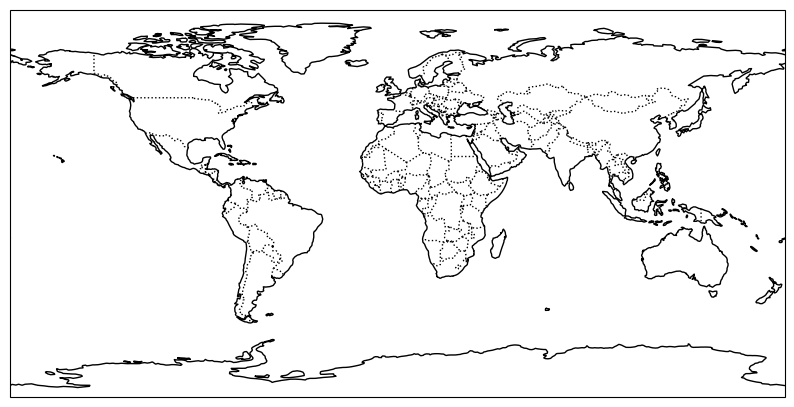

In [95]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
triangulation = tri.Triangulation(clon_vertices, clat_vertices, nv)
cs = ax.tripcolor(clon_vertices, clat_vertices, triangulation=triangulation, cmap='viridis', edgecolors='none',
                  transform=ccrs.PlateCarree(), c=clat_vertices)

cbar = plt.colorbar(cs, orientation='horizontal', pad=0.05)
cbar.set_label('k')
plt.title('ICON Grid Data Display')
plt.show()

### sec try

adapted from https://docs.dkrz.de/doc/visualization/sw/python/source_code/python-matplotlib-example-unstructured-icon-contour-plot-python-3.html

In [105]:
import time, os
import xarray as xr

import numpy as np
import numpy.ma as ma

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [106]:
Data = xr.open_dataset(output)

In [118]:
var9 = Data["t2m"].values[0]
var9 = var9 - 273.15
var21 = Data["t2m"].values[1]
var21 = var21 - 273.15

In [119]:
clon = np.rad2deg(Data.clon.values)
clat = np.rad2deg(Data.clat.values)

In [120]:
print("var shape", var9.shape)
print("clon shape", clon.shape)
print("clat shape", clat.shape)

var shape (81920,)
clon shape (81920,)
clat shape (81920,)


In [121]:
print(var9)

[-15.98478898 -16.09118915 -17.21098611 ...  10.83843558  12.28262332
  11.89465195]


In [122]:
varMin, varMax, varInt = -32, 28, 2
levels = np.arange(varMin, varMax + varInt, varInt)
nlevs = levels.size
labels = ['{:.2f}'.format(x) for x in levels]

In [126]:
print('')
print('Cells:            %6d ' % clon.size)
print('Variable9 min/max: %6.2f ' % np.nanmin(var9) + '/' + ' %.2f' % np.nanmax(var9))
print('Variable21 min/max: %6.2f ' % np.nanmin(var21) + '/' + ' %.2f' % np.nanmax(var21))
print('Contour  min/max: %6.2f ' % varMin + '/' + ' %.2f' % varMax)
print('')


Cells:             81920 
Variable9 min/max: -43.34 / 40.32
Variable21 min/max: -42.83 / 35.90
Contour  min/max: -32.00 / 28.00



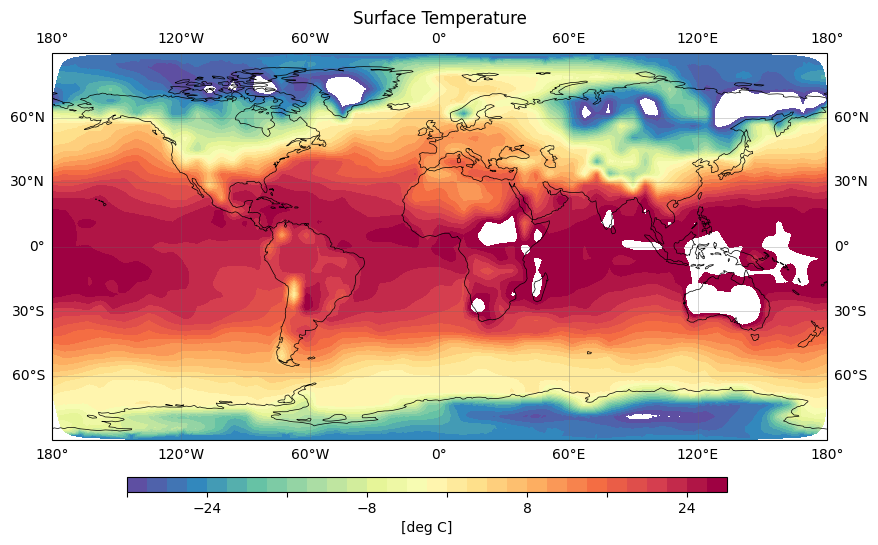

In [124]:
projection = ccrs.PlateCarree()
cmap = plt.get_cmap('Spectral_r', nlevs)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=projection))
ax.set_global()
ax.gridlines(draw_labels=True, linewidth=0.5, color='dimgray', alpha=0.4, zorder=2)
ax.coastlines(linewidth=0.5, zorder=2)
plt.title("Surface Temperature")
cnf = ax.tricontourf(clon, clat, var9, vmin=varMin, vmax=varMax, levels=levels, cmap=cmap, extend='neither', zorder=0)
cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.015], autoscalex_on=True)
cbar = fig.colorbar(cnf, cax=cbar_ax, orientation='horizontal')
plt.setp(cbar.ax.get_xticklabels()[::2], visible=False)
cbar.set_label('[deg C]')

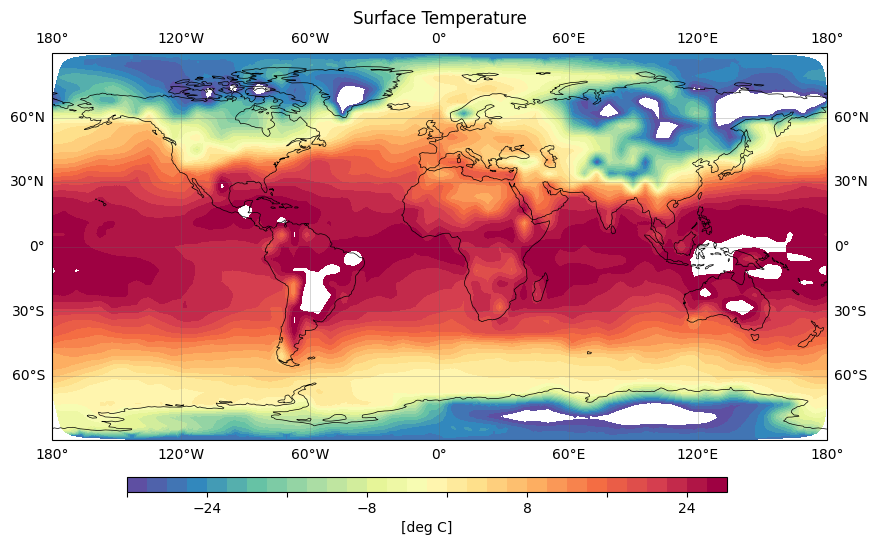

In [125]:
projection = ccrs.PlateCarree()
cmap = plt.get_cmap('Spectral_r', nlevs)
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection=projection))
ax.set_global()
ax.gridlines(draw_labels=True, linewidth=0.5, color='dimgray', alpha=0.4, zorder=2)
ax.coastlines(linewidth=0.5, zorder=2)
plt.title("Surface Temperature")
cnf = ax.tricontourf(clon, clat, var21, vmin=varMin, vmax=varMax, levels=levels, cmap=cmap, extend='neither', zorder=0)
cbar_ax = fig.add_axes([0.2, 0.25, 0.6, 0.015], autoscalex_on=True)
cbar = fig.colorbar(cnf, cax=cbar_ax, orientation='horizontal')
plt.setp(cbar.ax.get_xticklabels()[::2], visible=False)
cbar.set_label('[deg C]')